# Volatilidad implícita
## Introducción

**Julia Hernández Cárdenas**

Pensemos en un activo cualquiera, este activo refleja una varianza histórica que podemos observar y medir.

Este activo puede ser subjacente de distintos tipos de derivados y como bien sabemos esto significa que el precio de estos dependerá de las distintas caracteristicas de nuestro subjacente.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats

In [2]:

ticker = yf.Ticker('AAPL')
prices = ticker.history(period="2y")['Close']
calls = ticker.option_chain(ticker.options[0]).calls


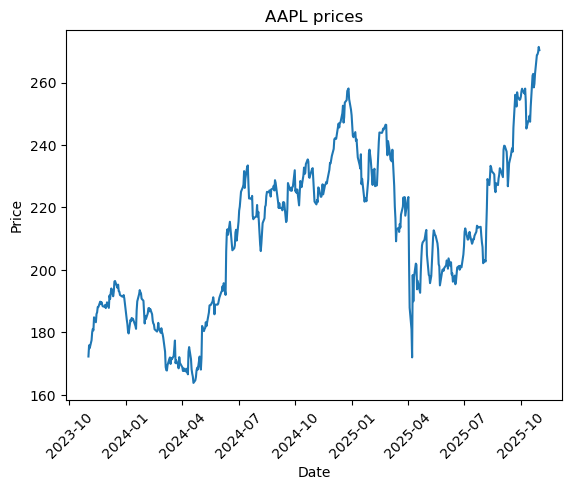

In [3]:
plt.plot(prices)
plt.title(f"{ticker.ticker} prices")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [4]:
current_price = prices.iloc[-1]
print("current price:",current_price)

current price: 270.3699951171875


Viendo el precio actual del activo y el histórico haga una estimacion vaga del precio de las siguientes opciones.

In [5]:
k=5
print(f"Expiration date: {ticker.options[0]}")
mask =(calls['strike']<=(current_price+k)) & (calls['strike']>=(current_price-k))
masked_calls = calls[mask][['contractSymbol','strike']]
masked_calls

Expiration date: 2025-11-07


,contractSymbol,strike
38,AAPL251107C00267500,267.5
39,AAPL251107C00270000,270.0
40,AAPL251107C00272500,272.5
41,AAPL251107C00275000,275.0


Podriamos usar otras herramisntas a nuestra dispocision para tener mas informacion y mejorar nuestra estimacion. Por ejemplo podemos calcular la probabilidad de que se ejecuten.

Si queremos calcular la probabilidad de que se ejecuten tenemos que usar el modelo
$$dS=S_0 \mu dt + S_0 \sigma dW$$

In [6]:
S_0 = current_price
mu = prices.pct_change().mean()
sigma = prices.pct_change().std()
t = (dt.datetime.today()-dt.datetime.strptime(ticker.options[0], "%Y-%m-%d")).days + 1
print(f"S_0: {current_price}")
print(f"mu: {mu}")
print(f"sigma: {sigma}")
print(f"dt: {t}")

S_0: 270.3699951171875
mu: 0.00105430738441854
sigma: 0.017677199744540864
dt: -4


Sabemos que el valor esperado del cambio en el precio del activo es

$$E[dS]=S_0 \mu dt$$

y la varianza esta dada por

$$Var[dS]= S_0^2 \sigma^2 dt$$


In [7]:
E = S_0*mu*t
Var = S_0**2*sigma**2*t
print(f"E[dS]: {E}")
print(f"Var[dS]: {Var}")

E[dS]: -1.1402123295090214
Var[dS]: -91.37006130132744


Con las siguientes probabilidades, ajusta tus estimaciones de cuanto crees que sea la prima de estas opciones call.

In [8]:
K = masked_calls['strike'].values
masked_calls['execution probability']=1-stats.norm.cdf((K-current_price),E,Var**0.5)
masked_calls

/var/folders/35/0jxsxnld78z8vjnqsg20btl00000gn/T/ipykernel_87508/3612538677.py:2: RuntimeWarning: invalid value encountered in scalar power
  masked_calls['execution probability']=1-stats.norm.cdf((K-current_price),E,Var**0.5)


,contractSymbol,strike,execution probability
38,AAPL251107C00267500,267.5,NaN
39,AAPL251107C00270000,270.0,NaN
40,AAPL251107C00272500,272.5,NaN
41,AAPL251107C00275000,275.0,NaN



### Precio justo de una opción (Black Scholes)

una herramienta mas potente para estimar el precio de las primas puede ser encontrar el precio justo usando black scholes

$$C(S, t) = S \cdot N(d_1) - K e^{-r(T-t)} \cdot N(d_2)$$

$$d_1 = \frac{\ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)(T-t)}{\sigma\sqrt{T-t}}$$

$$d_2 = d_1 - \sigma\sqrt{T-t}
$$


In [9]:
r = (1+0.071)**(1/255)-1
d1 = (np.log(S_0/K) + (r + sigma**2/2)*t)/(sigma*t**0.5)
d2 = d1 - sigma*t**0.5
C = S_0*stats.norm.cdf(d1) - K*np.exp(-r*t)*stats.norm.cdf(d2)
masked_calls['fair price'] = C
masked_calls

,contractSymbol,strike,execution probability,fair price
38,AAPL251107C00267500,267.5,NaN,1.290990+3.654713j
39,AAPL251107C00270000,270.0,NaN,0.039645+3.812905j
40,AAPL251107C00272500,272.5,NaN,-1.211701+3.708007j
41,AAPL251107C00275000,275.0,NaN,-2.463047+3.335231j


Con esta nueva informacion ajusta una ultima vez tus estimaciones de las primas.

Para este punto habran notado que el precio de la prima baja cuando las opciones son mas riesgosas y sube cuando son mas seguras, por lo que haciendo de lado variables que no podemos cambiar como el intervalo de tiempo, el precio del activo o la tasa libre de riesgo, el precio de la prima de una opcion se puede ver como una funcion de la varianza (o volatilidad) del activo.

En el mercado podemos observar las siguientes primas `lastPrice` que son cercanas pero distintas al precio justo que calculamos. Ahora pregúntate:

Qué tan cercana fue tu estimación?
A qué crees que se deba la diferencia entre el precio justo y la prima que vemos en el mercado?



In [10]:
calls[mask]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
38,AAPL251107C00267500,2025-10-31 19:59:19+00:00,267.5,5.26,5.15,5.40,-2.769999,-34.495636,3520.0,4245,0.302131,True,REGULAR,USD
39,AAPL251107C00270000,2025-10-31 19:59:58+00:00,270.0,3.79,3.65,3.90,-2.760000,-42.137410,30407.0,16332,0.294197,True,REGULAR,USD
40,AAPL251107C00272500,2025-10-31 19:59:59+00:00,272.5,2.61,2.47,2.63,-2.490000,-48.823530,32331.0,6888,0.283699,False,REGULAR,USD
41,AAPL251107C00275000,2025-10-31 19:59:59+00:00,275.0,1.60,1.58,1.72,-2.450000,-60.493830,40466.0,7205,0.280159,False,REGULAR,USD


La diferencia se debe a que en el mercado los precios de los derivados no son fijos, estan sujetos a movimientos segun su oferta y demanda.

Otra forma de ver esto es que el precio de la prima refleja la expectativa que el mercado tiene de la volatilidad en el periodo de la opcion.

Y si podemos calcular la prima en funcion a la volatilidad (Black Scholes), eso quiere decir que tambien podemos ver la volatilidad en funcion de la prima.

Para hacer esto podemos utilizar BS y metodos numericos:

In [11]:


from scipy.optimize import brentq

K=257.5
def BS(sigma):
  d1=(np.log(S_0/K)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
  d2=d1-sigma*np.sqrt(t)
  c=S_0*stats.norm.cdf(d1)-K*np.exp(-r*t)*stats.norm.cdf(d2)
  return c

def objective(sigma):
    return BS(sigma) - 2.74

implied_vol = brentq(objective, -0.01, 0.07, xtol=1e-6)
print(f"La volatilidad implícita es: {implied_vol:.6f}  vs {sigma}")



La volatilidad implícita es: 0.000001  vs 0.017677199744540864


/var/folders/35/0jxsxnld78z8vjnqsg20btl00000gn/T/ipykernel_87508/1563990692.py:5: RuntimeWarning: invalid value encountered in sqrt
  d1=(np.log(S_0/K)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
/var/folders/35/0jxsxnld78z8vjnqsg20btl00000gn/T/ipykernel_87508/1563990692.py:6: RuntimeWarning: invalid value encountered in sqrt
  d2=d1-sigma*np.sqrt(t)


## Tarea

Comparar la volatilidad implicita de un grupo de opciones de un activo. con la varianza observada en dicho periodo.

Para lograr esto tenemos que calcular la volatilidad implicita de las opciones hoy, guardar esta informacion y regresar despues del vencimiento pera calcular la volatilidad del activo desde hoy hasta la fecha de vencimiento, compara con distintos timeframes y reflexiona sobre los resultados encontrados.

# NOTAAAAAAAA

No pude recuperar el código con los datos de las opciones que obtuvimos en clase, pero en su momento les tomé foto a los resultados. Por eso definí la volatilidad implícita como dato nomás, sin cálculos (hasta el final del archivo adjunté también las imagenes con los resultados de las opciones que cerraban el 31 de Octubre).

In [12]:
S0 = 345.9599914550781
Mu = 0.0008797974862754135
dt = 8

In [13]:
ticker = "V"
snapshot_date = "2025-10-23"
expiry_date = "2025-10-31"
vol_implicita_23oct = 0.019387
dias = 252

df = yf.Ticker(ticker).history(
    start=pd.to_datetime(snapshot_date) - pd.Timedelta(days=3),
    end=pd.to_datetime(expiry_date) + pd.Timedelta(days=1)
)["Close"].dropna()

if getattr(df.index, "tz", None) is not None:
    df.index = df.index.tz_convert(None)

start = pd.to_datetime(snapshot_date)
end = pd.to_datetime(expiry_date)
df = df.loc[(df.index >= start) & (df.index <= end)]

In [14]:
df

Date
2025-10-23 04:00:00    345.959991
2025-10-24 04:00:00    347.380005
2025-10-27 04:00:00    347.820007
2025-10-28 04:00:00    346.899994
2025-10-29 04:00:00    341.279999
2025-10-30 04:00:00    345.029999
Name: Close, dtype: float64

In [15]:
def vol(close, k=1, trading_days=252):
    r_k = np.log(close).diff(k).dropna()
    r_daily_equiv = r_k / np.sqrt(k)
    return r_daily_equiv.std(ddof=1) * np.sqrt(trading_days)

vol_1d = vol(df, k=1)
vol_3d = vol(df, k=3)
vol_4d = vol(df, k=4)
vol_full = np.log(df).diff().dropna().std(ddof=1) * np.sqrt(dias)

In [16]:
V_1d_daily  = vol_1d/np.sqrt(dias)
V_3d_daily  = vol_3d/np.sqrt(dias)
V_4d_daily  = vol_4d/np.sqrt(dias)
V_full_daily= vol_full/np.sqrt(dias)

vol_data = pd.DataFrame({
    "vol implicita": [vol_implicita_23oct],
    "V_1d": [V_1d_daily],
    "V_3d": [V_3d_daily],
    "V_4d": [V_4d_daily],
    "V_full": [V_full_daily]
})
print(vol_data.applymap(lambda x: f"{x:.2%}"))

if vol_implicita_23oct > V_full_daily:
    print("La Vol. Implícita fue MAYOR que la Vol. Real -> sobreestimación.")
else:
    print("La Vol. Implícita fue MENOR que la Vol. Real -> subestimación.")


  vol implicita   V_1d   V_3d   V_4d V_full
0         1.94%  1.01%  0.59%  0.24%  1.01%
La Vol. Implícita fue MAYOR que la Vol. Real -> sobreestimación.


Después de calcular la volatilidad del periodo, dio como resultado que la volatilidad implícita que calculé en su momento fue mayor que la volatilidad real del periodo. Esto significa que el mercado sobreestimó el riesgo en este periodo, y que en realidad Visa se comportó de manera más estable de lo que se esperaba. La consecuencia de esto fue que las opciones estuvieron un poco caras, beneficiando más a los vendendores que a los compradores

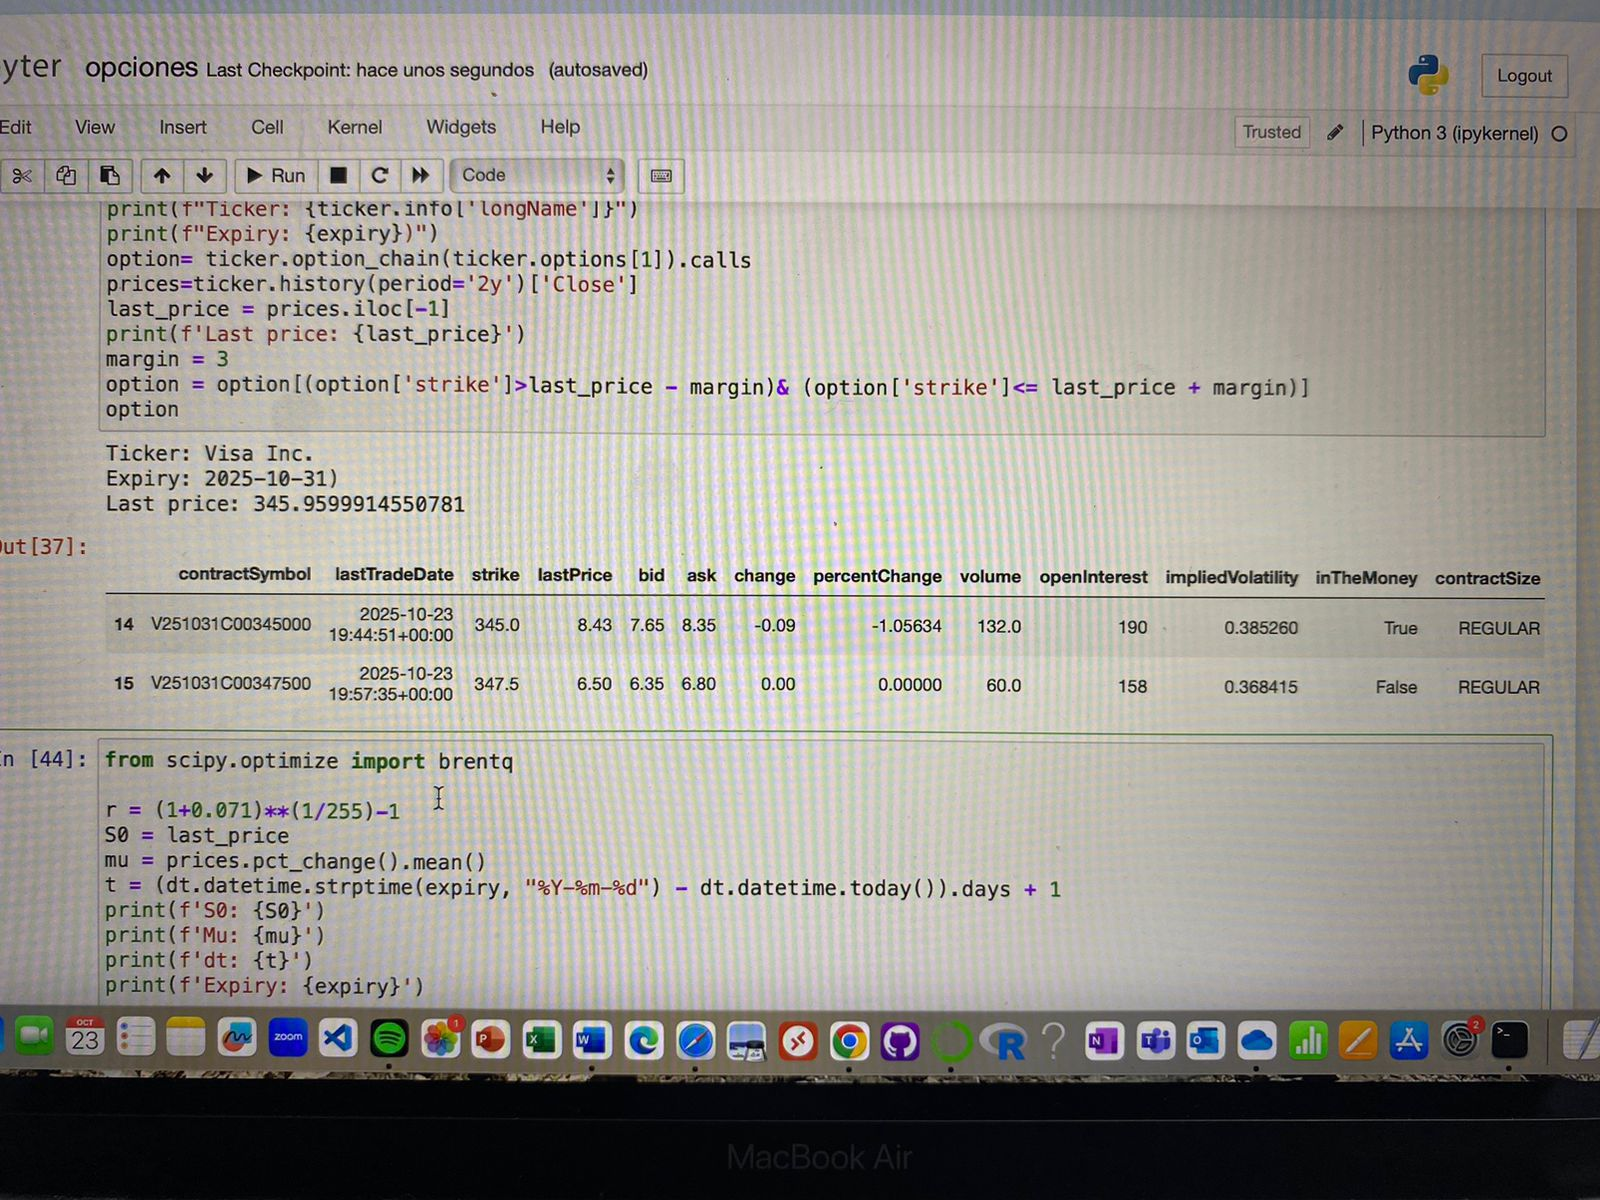

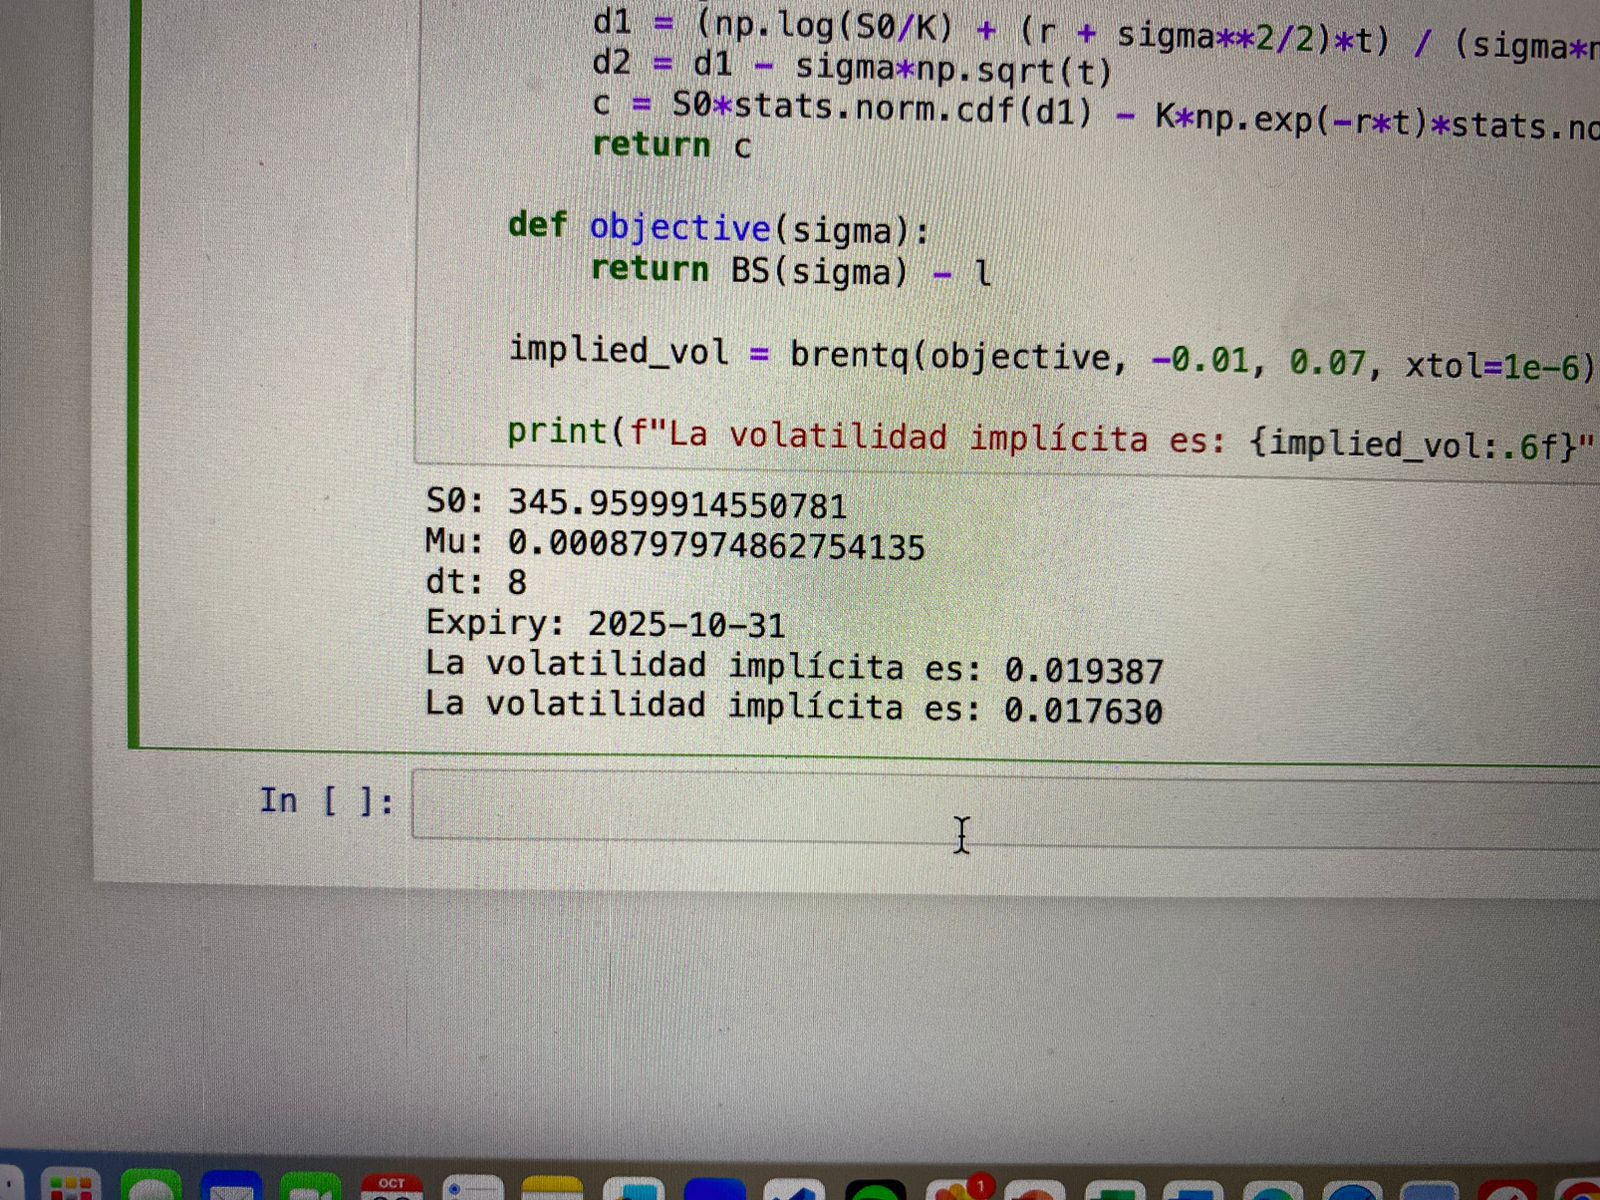

In [17]:
ticker = yf.Ticker('V')
expiry = ticker.options[1]
print(f"Ticker: {ticker.ticker}")
print(f"Expiry: {expiry}")
options = ticker.option_chain(expiry).calls
prices = ticker.history(period="2y")['Close']
last_price = prices.iloc[-1]
print(f"Last price: {last_price}")
margin = 5
options = options[(options['strike']>=last_price-margin) & (options['strike']<=last_price+margin)]
options

Ticker: V
Expiry: 2025-11-14
Last price: 340.739990234375


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
11,V251114C00337500,2025-10-31 13:37:15+00:00,337.5,8.36,7.75,8.45,-3.67,-30.507067,1.0,9,0.273384,True,REGULAR,USD
12,V251114C00340000,2025-10-31 19:54:37+00:00,340.0,7.05,6.35,6.95,-4.65,-39.743587,62.0,28,0.266975,True,REGULAR,USD
13,V251114C00342500,2025-10-31 19:46:33+00:00,342.5,5.85,5.10,5.65,-4.38,-42.815247,49.0,39,0.262703,False,REGULAR,USD
14,V251114C00345000,2025-10-31 19:55:23+00:00,345.0,4.40,3.95,4.55,-3.82,-46.472020,32.0,255,0.260383,False,REGULAR,USD


In [18]:
from scipy.optimize import brentq
import datetime as dt
import scipy.stats as stats
S_0 = last_price
mu = prices.pct_change().mean()
t = (dt.datetime.strptime(expiry, "%Y-%m-%d")-dt.datetime.today()).days + 2
r = (1+0.071)**(1/255)-1
print(f"S_0: {S_0}")
print(f"mu: {mu}")
print(f"dt: {t}")
print(f"expiry: {expiry}")
for K, l in zip(options['strike'], options['lastPrice']):
  def BS(sigma):
    d1=(np.log(S_0/K)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
    d2=d1-sigma*np.sqrt(t)
    c=S_0*stats.norm.cdf(d1)-K*np.exp(-r*t)*stats.norm.cdf(d2)
    return c

  def objective(sigma):
      return BS(sigma) - l

  implied_vol = brentq(objective, -0.01, 0.07, xtol=1e-6)
  print(f"La volatilidad implícita para strike en {K} es: {implied_vol:.6f}")


S_0: 340.739990234375
mu: 0.0008155761992197876
dt: 13
expiry: 2025-11-14
La volatilidad implícita para strike en 337.5 es: 0.012095
La volatilidad implícita para strike en 340.0 es: 0.012355
La volatilidad implícita para strike en 342.5 es: 0.012494
La volatilidad implícita para strike en 345.0 es: 0.011782
